# Anchors VS Minimal Sufficient Rules

In [1]:
import argparse
import numpy as np
# from acv_explainers.utils import generate_dataset
# from experiments.utils import feature_performance_metric, prediction_performance_metric   
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
# from skranger.ensemble.classifier import RangerForestClassifier
from sklearn.ensemble import RandomForestRegressor
from acv_explainers.acv_tree import ACVTreeAgnostic
# Necessary packages
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
import itertools
from collections import defaultdict
from operator import itemgetter
import string
import random
import scipy.stats as stats
from typing import Tuple, List
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn import datasets


## Generated moon dataset

In [2]:
def generate_x(n, dim):
    """Generate the features (x).

  Args:
    - n: the number of samples
    - dim: the number of features (feature dimensions)

  Returns:
    - x: (n x dim) data points sample from N(0, 1)
  """
    x = np.random.randn(n, dim)
    return x


def generate_y(x, data_type, reg=False, coefs=None, logit_values=True):
    """Generate corresponding label (y) given feature (x).

  Args:
    - x: features
    - data_type: synthetic data type (syn1 to syn6)

  Returns:
    - y: corresponding labels
  """
    # number of samples
    n = x.shape[0]
    if reg:
        if data_type == 'syn7':
            logit1 = np.sum(coefs[0:2] * x[:, 0:2], axis=1)
            logit2 = np.sum(coefs[2:4] * x[:, 2:4], axis=1)
            idx1 = (x[:, 4] < 0) * 1
            idx2 = (x[:, 4] >= 0) * 1
            logit = logit1 * idx1 + logit2 * idx2
            return logit
        elif data_type == 'syn8':
            return np.sum(coefs[:3] * x[:, :3], axis=1)
        elif data_type == 'syn9':
            logit1 = np.sum(x[:, 2:6] ** 2, axis=1) - 4.0
            logit2 = -10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                     x[:, 8] + np.exp(-x[:, 9]) - 2.4

            idx1 = (x[:, 10] < 0) * 1
            idx2 = (x[:, 10] >= 0) * 1
            logit = logit1 * idx1 + logit2 * idx2
            return logit

    # Logit computation
    if data_type == 'syn1':
        logit = np.exp(x[:, 0] * x[:, 1])
    elif data_type == 'syn2':
        logit = np.exp(np.sum(x[:, 2:6] ** 2, axis=1) - 4.0)
    elif data_type == 'syn3':
        logit = np.exp(-10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                       x[:, 8] + np.exp(-x[:, 9]) - 2.4)
    elif data_type == 'syn4':
        logit1 = np.exp(x[:, 0] * x[:, 1])
        logit2 = np.exp(np.sum(x[:, 2:6] ** 2, axis=1) - 4.0)
    elif data_type == 'syn5':
        logit1 = np.exp(x[:, 0] * x[:, 1])
        logit2 = np.exp(-10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                        x[:, 8] + np.exp(-x[:, 9]) - 2.4)
    elif data_type == 'syn6':
        logit1 = np.exp(np.sum(x[:, 2:6] ** 2, axis=1) - 4.0)
        logit2 = np.exp(-10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                        x[:, 8] + np.exp(-x[:, 9]) - 2.4)

        # For syn4, syn5 and syn6 only
    if data_type in ['syn4', 'syn5', 'syn6']:
        # Based on X[:,10], combine two logits
        idx1 = (x[:, 10] < 0) * 1
        idx2 = (x[:, 10] >= 0) * 1
        logit = logit1 * idx1 + logit2 * idx2

    if not logit_values:
        # Compute P(Y=0|X)
        prob_0 = np.reshape((logit / (1 + logit)), [n, 1])

        # # Sampling process
        y = np.zeros([n, 2])
        y[:, 0] = np.reshape(np.random.binomial(1, prob_0), [n, ])
        y[:, 1] = 1 - y[:, 0]
        return y[:, 1]
    return logit / (1 + logit)


def generate_ground_truth(x, data_type):
    """Generate ground truth feature importance corresponding to the data type
     and feature.

  Args:
    - x: features
    - data_type: synthetic data type (syn1 to syn6)

  Returns:
    - ground_truth: corresponding ground truth feature importance
  """

    # Number of samples and features
    n, d = x.shape

    # Output initialization
    ground_truth = np.zeros([n, d])

    # For each data_type
    if data_type == 'syn1':
        ground_truth[:, :2] = 1
    elif data_type == 'syn2':
        ground_truth[:, 2:6] = 1
    elif data_type == 'syn3':
        ground_truth[:, 6:10] = 1

    # Index for syn4, syn5 and syn6
    if data_type in ['syn4', 'syn5', 'syn6', 'syn9']:
        idx1 = np.where(x[:, 10] < 0)[0]
        idx2 = np.where(x[:, 10] >= 0)[0]
        ground_truth[:, 10] = 1

    if data_type == 'syn4':
        ground_truth[idx1, :2] = 1
        ground_truth[idx2, 2:6] = 1
    elif data_type == 'syn5':
        ground_truth[idx1, :2] = 1
        ground_truth[idx2, 6:10] = 1
    elif data_type == 'syn6':
        ground_truth[idx1, 2:6] = 1
        ground_truth[idx2, 6:10] = 1
    elif data_type == 'syn7':
        idx1 = np.where(x[:, 4] < 0)[0]
        idx2 = np.where(x[:, 4] >= 0)[0]
        ground_truth[:, 4] = 1

        ground_truth[idx1, 0:2] = 1
        ground_truth[idx2, 2:4] = 1
    elif data_type == 'syn8':
        ground_truth[:, :3] = 1
        # ground_truth[idx2, 6:10] = 1
    elif data_type == 'syn9':
        ground_truth[idx1, :2] = 1
        ground_truth[idx2, 6:10] = 1

    return ground_truth


def generate_moons(x):
    moon_x, y = datasets.make_moons(n_samples=x.shape[0], noise=4 * 0.01)
    x = np.concatenate([moon_x, x], axis=1)
    for i in range(x.shape[0]):
        if x[i, 2] <= 0:
            if y[i] == 0:
                y[i] = 1
            else:
                y[i] = 0
    ground_truth = np.zeros(shape=x.shape)
    ground_truth[:, :3] = 1
    return x, y, ground_truth


def generate_dataset(mean, cov, n=10000, dim=11, data_type='syn1', seed=0, reg=False, coefs=None, logit_values=True):
    """Generate dataset (x, y, ground_truth).

  Args:
    - n: the number of samples
    - dim: the number of dimensions
    - data_type: synthetic data type (syn1 to syn6)
    - seed: random seed

  Returns:
    - x: features
    - y: labels
    - ground_truth: ground truth feature importance
  """

    # Seed
    np.random.seed(seed)

    # x generation
    data_gen = st.multivariate_normal(mean, cov)
    x = data_gen.rvs(n)
    if data_type == 'syn_moons':
        x, y, ground_truth = generate_moons(x)
        return x, y, ground_truth

    # x = generate_x(n, dim)
    # y generation
    y = generate_y(x, data_type, reg, coefs, logit_values)
    # ground truth generation
    ground_truth = generate_ground_truth(x, data_type)

    return x, y, ground_truth


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument(
  '--data_type',
  choices=['syn1','syn2','syn3','syn4','syn5','syn6', 'syn7', 'syn8', 'syn_moons'],
  default='syn_moons',
  type=str)
parser.add_argument(
  '--train_no',
  help='the number of training data',
  default=10000,
  type=int)
parser.add_argument(
  '--test_no',
  help='the number of testing data',
  default=10000,
  type=int)
parser.add_argument(
  '--dim',
  help='the number of features',
  choices=[11, 100],
  default=50,
  type=int)

args = parser.parse_args([]) 

# Generate dataset
d = args.dim
p = 0.8
mean = np.zeros(d)
coefs = np.ones(d)
# Determinitist covariance
cov = p*np.ones(shape=(d, d)) + 5*np.eye(d)
# b = np.random.randn(d, d)
# cov = np.dot(b, b.T)

x_train, y_train, g_train = generate_dataset (mean, cov, n = args.train_no, 
                                            dim = args.dim, 
                                            data_type = args.data_type, 
                                            seed = 0, reg=True, coefs=coefs)

x_test, y_test, g_test = generate_dataset (mean, cov, n = args.test_no,
                                         dim = args.dim, 
                                         data_type = args.data_type, 
                                         seed = 5, reg=True, coefs=coefs)
# X_train = x_train.copy()
# X_test = x_test.copy()

In [4]:
max_size = 10000
x_train = pd.DataFrame(x_train[:max_size], columns=['X{}'.format(i) for i in range(x_train.shape[1])])
x_test = pd.DataFrame(x_test[:max_size], columns=['X{}'.format(i) for i in range(x_test.shape[1])])
y_test = pd.DataFrame(y_test[:max_size])
y_train = pd.DataFrame(y_train[:max_size])

In [5]:
y_train = y_train.values.squeeze()
y_test = y_test.values.squeeze()

### Train Explainer (ACXplainer)

In [6]:
from acv_explainers import ACXplainer

In [7]:
ac_explainer = ACXplainer(classifier=True, n_estimators=10, mtry=x_train.shape[1], max_depth=8, replace=False)
ac_explainer.fit(x_train, y_train)

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, ac_explainer.predict_proba(x_test)[:, 1])

0.9971953903148482

# Plot the Data

In [9]:
data_plots = x_train.copy()
data_plots['label'] = y_train

In [10]:
c = ['#3e82fc', '#ff073a']

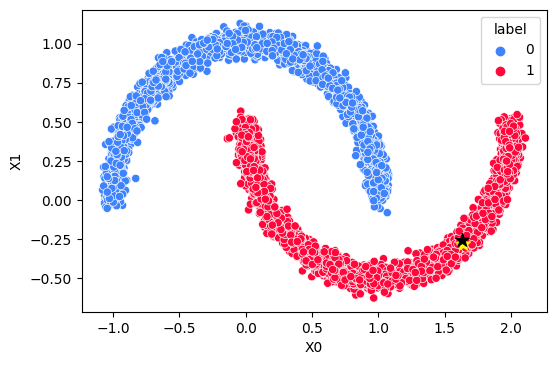

In [11]:
plt.figure(dpi=100)
sns.scatterplot(x='X0', y='X1', hue='label', data=data_plots[data_plots['X2']>=0], palette=c)

idx = np.random.randint(0, x_test.shape[0])
idx = 241

# Find a nearest neighbor 
nearest = (x_test.values[:, 0] <= x_test.values[idx, 0] + 0.05)*(x_test.values[:, 0] >= x_test.values[idx, 0] - 0.05) *\
(x_test.values[:, 1] <= x_test.values[idx, 1] + 0.05)*(x_test.values[:, 1] >= x_test.values[idx, 1] - 0.05)\
*(x_test.values[:, 2] * x_test.values[idx, 2]>=0)


idx_nb = np.argwhere(nearest==1).reshape(-1)[0]
plt.scatter(x_test.values[idx][0], x_test.values[idx][1], marker='*', c = 'yellow', s=100)

plt.scatter(x_test.values[idx_nb][0], x_test.values[idx_nb][1], marker='*', c = 'black', s=100)

- The instance chosen for the explanations

In [12]:
x_test.values[idx]

array([ 1.63645292, -0.2793297 ,  1.1650732 ,  1.88235015,  2.49913727,
       -1.64285735,  1.27680176,  2.45025881,  0.98483542,  1.399923  ,
        2.17315306, -2.01988491,  1.25697649,  3.67057427, -1.6332039 ,
        3.23049706,  0.97244603, -2.39847463,  1.70059623, -0.01561015,
       -1.17356708,  2.59495247, -1.91668032, -0.89221211,  0.96514319,
        3.38968788,  1.08474971, -1.80336752,  1.59423612, -1.20047646,
        0.13382636,  2.38093543,  1.02614918, -0.58335811,  2.75487779,
        2.80870358, -3.7982218 , -0.6960405 , -1.95697686, -0.83167336,
       -0.86123272,  3.4648318 , -1.53976004,  1.04271566,  6.63027349,
       -1.93127588,  2.63058311, -0.36321488, -2.44844684, -0.55983083,
        7.01145599,  1.33260344])

- The nearest point of the chosen instance 

In [13]:
x_test.values[idx_nb]

array([ 1.63088441, -0.25730066,  0.20338427,  1.17814416, -2.6493092 ,
        0.22126136, -3.96573552, -1.35014364, -0.86752407,  0.98335055,
       -1.64288684, -3.75673208, -3.7682473 , -1.34598429,  2.2540965 ,
        0.66347964, -2.23927705,  1.33631652, -3.2965628 , -2.75256269,
        1.18059732, -1.76704693,  1.17167364, -2.51065328, -0.84983104,
       -2.96633617, -3.07332822,  1.46168502,  1.40754213, -4.34082663,
       -0.06708767, -0.39437461, -1.6966872 , -4.24897085, -1.31074416,
       -1.58809364,  2.72170277,  2.60363464,  1.83307095, -0.29065748,
        3.89778162, -0.0605856 ,  1.29259719, -0.82891234, -2.03805243,
       -5.56735686,  0.69744213,  0.22037855, -0.74372118,  0.00772882,
       -2.99636024,  0.92686732])

# Anchors Fitting

In [14]:
from anchor import anchor_tabular

In [15]:
columns = ['X{}'.format(i) for i in range(x_train.shape[1])]

In [16]:
explainer = anchor_tabular.AnchorTabularExplainer(
    ['0', '1'],
    columns,
    x_train.values)

#### Rules of the reference point

In [17]:
# idx = 607
import time
t0 = time.perf_counter()
exp = explainer.explain_instance(x_test.values[idx], ac_explainer.model.predict, threshold=0.95, delta=0.05, max_anchor_size=5)
t1 = time.perf_counter()
print(t1 - t0)
exp.names()

66.88029608400001


['X32 <= 1.62', 'X44 > 1.66', 'X9 > -1.66', 'X0 > -0.03', 'X2 > 0.01']

In [18]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: X32 <= 1.62 AND X44 > 1.66 AND X9 > -1.66 AND X0 > -0.03 AND X2 > 0.01
Precision: 0.70
Coverage: 0.06


#### Rules of the nearest point

In [19]:
for i in range(4):

    import time
    t0 = time.perf_counter()
    exp = explainer.explain_instance(x_test.values[idx_nb], ac_explainer.model.predict, threshold=0.95, delta=0.05, max_anchor_size=30)
    t1 = time.perf_counter()
print(t1 - t0)
exp.names()

48.016825063


['X45 <= -1.57', 'X28 > 0.01', 'X0 > 1.04', 'X2 > 0.01', 'X1 <= -0.20']

In [20]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: X45 <= -1.57 AND X28 > 0.01 AND X0 > 1.04 AND X2 > 0.01 AND X1 <= -0.20
Precision: 1.00
Coverage: 0.01


In [21]:
X = x_train.values.copy()
plot_step = 0.01

# Sufficient Explanations and Sufficient Rules

### 1- Sufficient Explanations

In [22]:
# idx = 0
# sufficient_coal, sdp_coal, sdp_global = ac_explainer.sufficient_expl_rf(x_test.values[idx_nb:idx_nb+1], y_test[idx_nb:idx_nb+1].reshape(-1).astype(np.double),
#                                                                 x_train.values[:10000], y_train[:10000].reshape(-1).astype(np.double),
#                                                                 stop=False, pi_level=0.95, t=10)

# sufficient_coal[0].pop(0)
# sufficient_coal = sufficient_coal[0]
# sufficient_coal

# S0 = sufficient_coal[0]
# S1 = sufficient_coal[1]

In [23]:
S0 = [0, 2]
S1 = [1, 2]

In [24]:
print('Index of the Sufficient Explanations X_{}, X_{}'.format(S0, S1))

Index of the Sufficient Explanations X_[0, 2], X_[1, 2]


### 2- Sufficient Rules

In [25]:
ns = x_train.shape[0]
tn = np.ceil(np.sqrt(ns) * np.log(ns)**(1.5) / 250)

In [26]:
sdp, rules, sdp_all, rules_data, w = ac_explainer.compute_sdp_maxrules(x_test.values[idx:idx+1], y_test[idx:idx+1].astype(np.double),
                                                         x_train, y_train.astype(np.double), [S0], verbose=True,
                                                                       min_node_size=tn)


rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S0]
rule_string = ' and '.join(rule_string)

print('The Sufficient rule when S={} is \n= {}'.format(S0, rule_string))

# Rule by SDP of the reference point with S1
sdp, rules, sdp_all, rules_data, w = ac_explainer.compute_sdp_maxrules(x_test.values[idx:idx+1], y_test[idx:idx+1].astype(np.double),
                                                         x_train, y_train.astype(np.double), [S1], verbose=True,
                                                                       min_node_size=tn)

rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S1]
rule_string = ' and '.join(rule_string)


# Rule by SDP of the nearest point with S1
print('The Sufficient rule when S={} is \n= {}'.format(S1, rule_string))


100%|█████████████████████████████████████████████| 1/1 [00:34<00:00, 34.19s/it]


The Sufficient rule when S=[0, 2] is 
= 1.4525739203424117 <= X0 <= inf and 0.16052448619447984 <= X2 <= inf


100%|█████████████████████████████████████████████| 1/1 [00:35<00:00, 35.35s/it]

The Sufficient rule when S=[1, 2] is 
= -inf <= X1 <= -0.14392577469514237 and 0.16052448619447984 <= X2 <= inf


#### Rule of the nearest point 

In [27]:
sdp, rules, sdp_all, rules_data, w = ac_explainer.compute_sdp_maxrules(x_test.values[idx_nb:idx_nb+1], y_test[idx_nb:idx_nb+1].astype(np.double),
                                                         x_train, y_train.astype(np.double), [S0], verbose=True,
                                                                       min_node_size=tn)


rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S0]
rule_string = ' and '.join(rule_string)

print('The Sufficient rule when S={} is \n= {}'.format(S0, rule_string))

# Rule by SDP of the reference point with S1
sdp, rules, sdp_all, rules_data, w = ac_explainer.compute_sdp_maxrules(x_test.values[idx_nb:idx_nb+1], y_test[idx_nb:idx_nb+1].astype(np.double),
                                                         x_train, y_train.astype(np.double), [S1], verbose=True,
                                                                       min_node_size=tn)

# from tqdm import tqdm

# pi_level = 0.6
# for a, ru in tqdm(enumerate(rules)):
#     rules_comp = [rules_data[a, j] for j in range(rules_data.shape[1]) if sdp_all[a, j] >= sdp[a]]
#     r, _ = return_best(rules[a], rules_comp, S1)
#     rules[a][S1] = r
    
rule = rules[0]
columns = [x_train.columns[i] for i in range(x_train.shape[1])]
rule_string = ['{} <= {} <= {}'.format(rule[i, 0] if rule[i, 0] > -1e+10 else -np.inf, columns[i],
                                       rule[i, 1] if rule[i, 1] < 1e+10 else +np.inf) for i in S1]
rule_string = ' and '.join(rule_string)


# Rule by SDP of the nearest point with S1
print('The Sufficient rule when S={} is \n= {}'.format(S1, rule_string))


100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.72s/it]


The Sufficient rule when S=[0, 2] is 
= 1.4525739203424117 <= X0 <= inf and 0.16052448619447984 <= X2 <= inf


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.76s/it]

The Sufficient rule when S=[1, 2] is 
= -inf <= X1 <= -0.14392577469514237 and 0.16052448619447984 <= X2 <= inf


### 3- Plot the rules

(-1.5, 2.0)

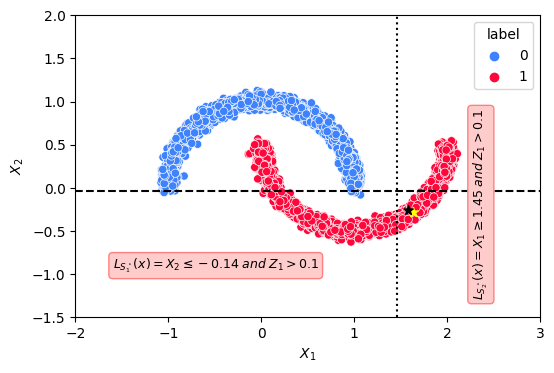

In [28]:
plt.figure(dpi=100)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plot_X = np.c_[xx.ravel(), yy.ravel()]

def rule(X):
    Y = []
    A = []
    j = 0
    for i in range(X.shape[0]):
        if X[i, 1] <=  -0.14392577469514237 and  1.457438946406726  <= X[i, 0]:
            j += 1
            Y.append(0)
        elif X[i, 1] >=  -0.14392577469514237 and  1.457438946406726 <= X[i, 0]:
            Y.append(1)
        elif X[i, 1] <= -0.14392577469514237 and  1.457438946406726  >= X[i, 0]:
            Y.append(1)
        else:
            Y.append(4)
    return np.array(Y), np.array(A)

Z, A = rule(plot_X)
Z = Z.reshape(xx.shape)
# A = A.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, colors='white', linestyles='dashed')
# cs = plt.contourf(xx, yy, A)
# plt.colorbar()
sns.scatterplot(x='X0', y='X1', hue='label', data=data_plots[data_plots["X2"]>=0], palette=c)
plt.scatter(x_test.values[idx][0], x_test.values[idx][1], marker='*', c ='yellow', s=50)
plt.scatter(x_test.values[idx_nb][0]-0.05, x_test.values[idx_nb][1], marker='*', c ='black', s=50)
x = np.linspace(-2, 3, 100)
y = np.ones(100)*(-0.0323284026235342)
plt.plot(x, y, linestyle='dashed', color='black')
# plt.plot(-2*np.ones(100), np.linspace(-1.5, y[0], 100), linestyle='dashed', color='black')

plt.text(x[20]+0.5, y[20]-0.9, r"$L_{S^\star_1}(x)=  X_2 \leq -0.14 \; and \; Z_1 > 0.1$",
         horizontalalignment='center', fontsize=9, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))


x = np.ones(100)*1.4608486890792847 
y = np.linspace(-1.5, 2, 100)
plt.plot(x, y, linestyle='dotted', color='black')

plt.text(x[20]+0.8, y[20]+0.6, r"$L_{S^\star_2}(x)=  X_1 \geq 1.45 \; and \; Z_1 > 0.1$",
         verticalalignment='center', fontsize=9, rotation='vertical', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))

plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.xlim(-2, 3)
plt.ylim(-1.5, 2)